# XOR
Train a MLP with 2 layers, 5 neurons on each to solve the classic XOR problem, which is a non-linearly separable problem, and thus the reason we need at least 2 layers. Tanh are chosen as the hidden activation functions and the output function is a softmax. The MLP is trained to minimized a Categorical Cross-Entropy performance index.

New Code
- One-hot-encoding targets with keras.utils.to_categorical.
- Using Categorical Cross-Entropy performance index and accuracy metric on model.compile
- Softmax output function for multiclass classification.
- Getting actual predictions using np.argmax on the output of model.predict.
- Accesing model weights and biases and plotting simple Decision Boundaries.

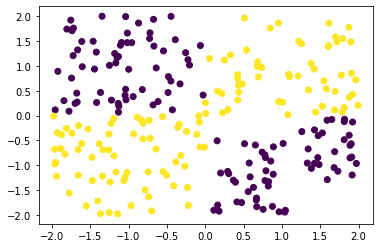

In [2]:
import numpy as np
import matplotlib.pyplot as plt
x = np.random.uniform(low=-2, high=2, size=500).reshape((250,2))
y = np.zeros(250)
y[np.logical_and(x[:,0]>0 , x[:,1]>0)]=1
y[np.logical_and(x[:,0]<0 , x[:,1]<0)]=1
plt.scatter(x[:,0],x[:,1],c=y)

## Keras

Using TensorFlow backend.


The MLP accuracy is 96.39999999999999 %


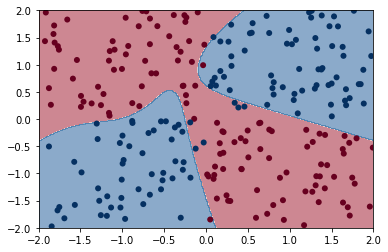

In [3]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.initializers import glorot_uniform

# %% ----------------------------------- Hyper Parameters --------------------------------------------------------------
LR = 0.02
N_NEURONS = 5
N_EPOCHS = 1000


# %% ----------------------------------- Helper Functions --------------------------------------------------------------
def acc(x, y):
    """ Simple function to get the accuracy. The label with the highest prob is chosen """
    # model.evaluate can also be used, this is just to illustrate the argmax operation
    probs = model.predict(x)  # (n_examples, n_labels) --> Need to operate on columns, so axis=1 on argmax
    pred_labels = np.argmax(probs, axis=1)
    return 100*accuracy_score(np.argmax(y, axis=1), pred_labels)  # Uses argmax again to come back from one-hot-encoded


# %% -------------------------------------- Data Prep ------------------------------------------------------------------
X = np.random.uniform(low=-2, high=2, size=500).reshape((250,2))
y = np.zeros(250)
y[np.logical_and(X[:,0]>0 , X[:,1]>0)]=1
y[np.logical_and(X[:,0]<0 , X[:,1]<0)]=1
# One-hot-encodes the targets to use the softmax and categorical cross-entropy performance index
Y = to_categorical(y, num_classes=2)

# %% -------------------------------------- Training Prep --------------------------------------------------------------
model = Sequential([
    Dense(N_NEURONS, input_dim=2),
    Activation("sigmoid"),
    Dense(2),  # Output layer with softmax to map to the two classes
    Activation("softmax")
])
# Compiles using categorical cross-entropy performance index and tracks the accuracy during training
model.compile(optimizer=Adam(lr=LR), loss="categorical_crossentropy", metrics=["accuracy"])

# %% -------------------------------------- Training Loop --------------------------------------------------------------
model.fit(X, Y, batch_size=len(X), epochs=N_EPOCHS, verbose=0)

# %% -------------------------------------- Check Approx ---------------------------------------------------------------
print("The MLP accuracy is", acc(X, Y), "%")

# %% -------------------------------------- Plot Decision Boundary ---------------------------------------------------------------
a, b = list(list(zip(*X)))
x_span = np.linspace(-2, 2, 500)
y_span = np.linspace(-2, 2, 500)
xx, yy = np.meshgrid(x_span, y_span)
labels = model.predict_classes(np.c_[xx.ravel(), yy.ravel()])
z = labels.reshape(xx.shape)
fig, ax = plt.subplots()
ax.contourf(xx, yy, z, cmap='RdBu', alpha=0.5)

# Get predicted labels on training data and plot
ax.scatter(a, b, c=y, cmap='RdBu', lw=0)
plt.show()

## TensorFlow


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 0 | Loss 0.79561
Epoch 1000 | Loss 0.12667
Epoch 2000 | Loss 0.08585
Epoch 3000 | Loss 0.07155
Epoch 4000 | Loss 0.06359
98.4


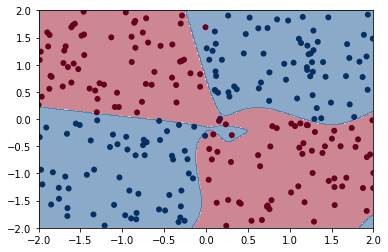

In [4]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import tensorflow as tf

# %% ----------------------------------- Hyper Parameters --------------------------------------------------------------
LR = 0.02
N_NEURONS = 5
N_EPOCHS = 5000
PRINT_LOSS_EVERY = 1000


# %% -------------------------------------- MLP Class ------------------------------------------------------------------
class MLP(tf.keras.Model):
    def __init__(self, hidden_dim):
        super(MLP, self).__init__()
        self.linear1 = tf.keras.layers.Dense(hidden_dim, input_shape=(2,))
        self.act1 = tf.nn.sigmoid
        self.linear2 = tf.keras.layers.Dense(2)

    def call(self, x):
        return self.linear2(self.act1(self.linear1(x)))


# %% -------------------------------------- Data Prep ------------------------------------------------------------------
X = np.random.uniform(low=-2, high=2, size=500).reshape((250,2))
y = np.zeros(250)
y[np.logical_and(X[:,0]>0 , X[:,1]>0)]=1
y[np.logical_and(X[:,0]<0 , X[:,1]<0)]=1
p = tf.convert_to_tensor(X)
t = tf.convert_to_tensor(y)

# %% -------------------------------------- Training Prep --------------------------------------------------------------
model = MLP(N_NEURONS)
optimizer = optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
# A classification problem is usually approached with a Categorical Cross-Entropy performance index
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # This one combines both the loss and the
# Log-SoftMax output function, which computes the probabilities of each example belonging to each class
# This is the preferred way as its computation is more stable. Thus, there is no need to include the
# SoftMax/Log-SoftMax output function on the model itself
# To keep track of the training loss, this will accumulate over each call if not reset
train_loss = tf.keras.metrics.Mean(name='train_loss')
# This decorator converts the eager execution code (Dynamic Graph) into a Static Graph. This means the first time train
# is called on line 60, the graph is built and then when it's called a second time it does not have to be built again
# See https://pgaleone.eu/tensorflow/tf.function/2019/03/21/dissecting-tf-function-part-1/ for an in-depth explanation.
# Note that this only allows for debugging on the first forward pass! (The graph is actually being built more than once
# due to TensorFlow internals stuff, but very infrequently). If you put a break point on line 24 and debug, it will
# stop there. If you click Resume Program, it will not stop there on the third forward pass. Now try doing the same
# thing after commenting the decorator (line 48). You will notice the debugger will stop on line 24 every single time.
@tf.function
def train():
    with tf.GradientTape() as tape:
        logits = model(p)
        loss = criterion(t, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)


# %% -------------------------------------- Training Loop --------------------------------------------------------------
for epoch in range(N_EPOCHS):
    train()
    if epoch % PRINT_LOSS_EVERY == 0:
        print("Epoch {} | Loss {:.5f}".format(epoch, train_loss.result()))
    train_loss.reset_states()  # Resets the metric for the next epoch

# %% -------------------------------------- Check Approx ---------------------------------------------------------------
print(accuracy_score(t.numpy(), tf.argmax(model(p), axis=1).numpy())*100)

# %% -------------------------------------- Plot Decision Boundary ---------------------------------------------------------------
a, b = list(list(zip(*X)))
x_span = np.linspace(-2, 2, 500)
y_span = np.linspace(-2, 2, 500)
xx, yy = np.meshgrid(x_span, y_span)
X_Y_span = tf.convert_to_tensor(np.c_[xx.ravel(), yy.ravel()])
logit = model(X_Y_span)
labels = np.argmax(logit.numpy(), axis=1)
z = labels.reshape(xx.shape)
fig, ax = plt.subplots()
ax.contourf(xx, yy, z, cmap='RdBu', alpha=0.5)


# Get predicted labels on training data and plot
ax.scatter(a, b, c=t, cmap='RdBu', lw=0)
plt.show()

## PyTorch

Epoch 0 | Loss 0.89469
Epoch 1000 | Loss 0.09654
Epoch 2000 | Loss 0.03849
Epoch 3000 | Loss 0.02509
Epoch 4000 | Loss 0.01788
100.0


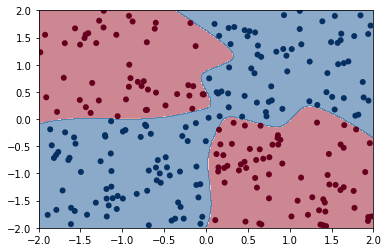

In [5]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import torch
import torch.nn as nn

# %% ----------------------------------- Hyper Parameters --------------------------------------------------------------
LR = 0.02
N_NEURONS = 5
N_EPOCHS = 5000
PRINT_LOSS_EVERY = 1000


# %% -------------------------------------- MLP Class ------------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, hidden_dim):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(2, hidden_dim)
        self.act1 = torch.sigmoid
        self.linear2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        return self.linear2(self.act1(self.linear1(x)))


# %% -------------------------------------- Data Prep ------------------------------------------------------------------
X = np.random.uniform(low=-2, high=2, size=500).reshape((250,2))
y = np.zeros(250)
y[np.logical_and(X[:,0]>0 , X[:,1]>0)]=1
y[np.logical_and(X[:,0]<0 , X[:,1]<0)]=1
p = torch.FloatTensor(X)
p.requires_grad = True
t = torch.Tensor(y).long()

# %% -------------------------------------- Training Prep --------------------------------------------------------------
model = MLP(N_NEURONS)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# A classification problem is usually approached with a Categorical Cross-Entropy performance index
criterion = nn.CrossEntropyLoss()  # This one combines both the loss and the Log-SoftMax output function,
# which computes the probabilities of each example belonging to each class
# This is the preferred way as its computation is more stable. Thus, there is no need to include the
# SoftMax/Log-SoftMax output function on the model itself

# %% -------------------------------------- Training Loop --------------------------------------------------------------
for epoch in range(N_EPOCHS):
    optimizer.zero_grad()
    logits = model(p)
    loss = criterion(logits, t)
    loss.backward()
    optimizer.step()
    if epoch % PRINT_LOSS_EVERY == 0:
        print("Epoch {} | Loss {:.5f}".format(epoch, loss.item()))

# %% -------------------------------------- Check Approx ---------------------------------------------------------------
print(accuracy_score(t.numpy(), np.argmax(logits.detach().numpy(), axis=1))*100)

# %% -------------------------------------- Plot Decision Boundary ---------------------------------------------------------------
a, b = list(list(zip(*X)))
x_span = np.linspace(-2, 2, 500)
y_span = np.linspace(-2, 2, 500)
xx, yy = np.meshgrid(x_span, y_span)
X_Y_span = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
logit = model(X_Y_span)
labels = np.argmax(logit.detach().numpy(), axis=1)
z = labels.reshape(xx.shape)
fig, ax = plt.subplots()
ax.contourf(xx, yy, z, cmap='RdBu', alpha=0.5)


# Get predicted labels on training data and plot
ax.scatter(a, b, c=t, cmap='RdBu', lw=0)
plt.show()

# Exercise: Train a circular Decision Boundary using  MLP

In [7]:
# %% -------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------
# Learn a circular Decision Boundary using  MLP
# ---------------------------------------------

# 1. Define a function to generate the y-points for a circle, taking as input the x-points and the radius r.

# 2. Use this function to generate the data to train the network. Label points with r=2 as 0 and points with r=4 as 1.
# Note that for each value on the x-axis there should be two values on the y-axis, and vice versa.

# 3. Choose the right number of input and output neurons, define and train a MLP to classify this data.

# 4. Make a contour plot of the MLP as a function of the x and y axis. You can follow
# https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_versus_svm_iris.html

# %% -------------------------------------------------------------------------------------------------------------------


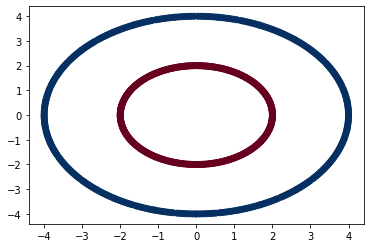

In [8]:
def get_single_circle(radius):
    angles = np.arange(0, 360, 1)
    x1 = np.cos(angles) * radius
    y1 = np.sin(angles) * radius

    return x1, y1

# 2. Use this function to generate the data to train the network. Label points with r=2 as 0 and points with r=4 as 1.
# Note that for each value on the x-axis there should be two values on the y-axis, and vice versa.
x1, y1 = get_single_circle(radius=2)
x2, y2 = get_single_circle(radius=4)
c1 = np.column_stack((x1, y1))
c2 = np.column_stack((x2, y2))
X = np.concatenate([c1, c2], axis=0)
y = np.zeros(X.shape[0])
y[c1.shape[0]:] = 1

# plot the training points
a, b = list(list(zip(*X)))
plt.scatter(a, b, c=y, cmap='RdBu')
plt.show()